### 套件預處理

In [64]:
# !pip install keras_cv
# !pip install wandb
# !pip install imblearn

In [65]:
import pandas as pd
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import keras_cv as kcv
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import BatchNormalization, Input
from keras.applications import VGG16
from keras import Model
from keras.utils import to_categorical
from keras.utils import image_dataset_from_directory
from keras.applications import EfficientNetB0, ResNet50V2, ConvNeXtBase
from keras.losses import CategoricalCrossentropy
from keras.optimizers import RMSprop, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from keras.callbacks import Callback
from collections import Counter
from sklearn.utils import class_weight

rand_augment = kcv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    geometric=True,
    rate=0.7,
    )

cut_mix = kcv.layers.CutMix()
mix_up = kcv.layers.MixUp()

le = LabelEncoder()
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'

In [66]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 超參數

In [67]:
configs = dict(
    train_dir = "./nptu-dl-final-project/train",
    train_csv = "./nptu-dl-final-project/train.csv",
    num_classes = 3,
    batch_size = 32,
    image_size = (224, 224),
    earlystopping_patience = 3,
    warmup_learning_rate = 1e-3,
    initial_learning_rate = 1e-4,
    epochs = 3,
    test_dir = ' 你的資料夾網址',
    
    model_name = 'resnet50', #resnet50, efficientnet
    advanced_aug = 'none', # none, cutmix, mixup, or cutmix_mixup 
    seed = 42, # the random seed
)
# 儲存 label名稱，和 label id 的對照表 (之後要建立 submission 檔用的)
LABEL_TBL = 'label_table.csv'
AUTO = tf.data.AUTOTUNE

keras.utils.set_random_seed(configs['seed'])

### 照片處理

In [68]:
def update_img_name(row, path):
    """
    本函式會把每張圖片加上路徑
    """
    return f'{path}/{row.image_id}'

In [69]:
# Label encoder 將 comment 編碼成數字
def check_image_exist(row):
    return os.path.exists(row.image_id)
le = LabelEncoder()
dffiles = pd.read_csv(configs['train_csv'])
dffiles['label'] = le.fit_transform(dffiles.label)
dffiles.head()

print(f"Num of Label Encoder {len(le.classes_)}")
print(f"Type of Label Encoder {le.classes_}")

Num of Label Encoder 109
Type of Label Encoder ['air hockey' 'ampute football' 'archery' 'arm wrestling' 'axe throwing'
 'badminton' 'balance beam' 'barell racing' 'baseball' 'basketball'
 'baton twirling' 'bike polo' 'billiards' 'bmx' 'bobsled' 'bowling'
 'boxing' 'bull riding' 'bungee jumping' 'canoe slamon' 'cheerleading'
 'chess' 'chuckwagon racing' 'cricket' 'croquet' 'curling' 'disc golf'
 'fencing' 'field hockey' 'figure skating men' 'figure skating pairs'
 'figure skating women' 'fly fishing' 'football' 'formula 1 racing'
 'frisbee' 'gaga' 'giant slalom' 'golf' 'gymnastics' 'hammer throw'
 'hang gliding' 'harness racing' 'high jump' 'hockey' 'horse jumping'
 'horse racing' 'horseshoe pitching' 'hurdles' 'hydroplane racing'
 'ice climbing' 'ice yachting' 'ice_hockey' 'jai alai' 'javelin'
 'jousting' 'judo' 'kabaddi' 'lacrosse' 'log rolling' 'luge' 'motogp'
 'motorcycle racing' 'mushing' 'nascar racing' 'olympic wrestling'
 'parallel bar' 'pole climbing' 'pole dancing' 'pole vaul

In [70]:
label_name = le.classes_
label_id = le.transform(le.classes_)
df = pd.DataFrame({
    'label_name':label_name,
    'label_id':label_id
})
# df.to_csv(LABEL_TBL, index=None)
df.head()

,label_name,label_id
0,air hockey,0
1,ampute football,1
2,archery,2
3,arm wrestling,3
4,axe throwing,4


In [71]:
dffiles.label.value_counts(normalize=True)

label
5      0.032044
33     0.031517
93     0.031057
8      0.030859
34     0.030201
         ...   
101    0.003948
63     0.003882
98     0.003750
3      0.003290
84     0.002632
Name: proportion, Length: 109, dtype: float64

### 訓練模型預處理

In [72]:
preprocess_map = {
    'efficientnetb0': keras.applications.efficientnet.preprocess_input,
    'resnet50': keras.applications.resnet_v2.preprocess_input,
    'convnextbase': keras.applications.convnext.preprocess_input 
}

def get_preprocess_func(model_name):
    return preprocess_map[model_name]

In [73]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_image(file_bytes, channels=3, expand_animations = False) 
    image = tf.image.resize(image, configs['image_size'][:2], method="bilinear")
    image = tf.cast(image, tf.float32) 
    
    if label is not None:
        label = tf.one_hot(label, configs['num_classes'])
    
    #label = tf.cast(label, tf.float32)
    if label is not None:
        return {"images": image, "labels": label}
    else:
        return {"images": image}

In [74]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(10, 10)).suptitle(title, fontsize=14)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples[0]
        labels = samples[1] 
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy())
        # draw the one-hot label on the top of image
        label = ','.join([str(f'{i:.2f}') for i in labels[0].numpy()])

        plt.title(f'[{label}]', fontsize=10)
        plt.axis("off")
    plt.show()

### 資料擴增

In [75]:
def apply_base_augmentation(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

def apply_cutmix_augmentation(inputs):
    inputs = cut_mix(inputs, training=True)
    return inputs

def apply_mixup_augmentation(inputs):
    inputs = mix_up(inputs, training=True)
    return inputs

def apply_cutmix_mixup_augmentation(inputs):
    inputs = cut_mix(inputs, training=True)
    inputs = mix_up(inputs, training=True)  
    return inputs

### 讀取資料

In [76]:
def get_train_val_dataframes(filename, test_size=0.2):
    dffiles = pd.read_csv(filename)
    dffiles.image_id = dffiles.apply(update_img_name, args=(configs['train_dir'],), axis=1)
    dffiles['label'] = le.fit_transform(dffiles.label)
    x=dffiles.image_id
    y=dffiles.label
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=test_size,random_state=0,stratify=y)
    dftrain = pd.concat((x_train,y_train), axis=1)
    dfval = pd.concat((x_val,y_val), axis=1)

    return dftrain, dfval

def get_test_dataframe(filename):
    dffiles = pd.read_csv(filename)
    dffiles.image_id = dffiles.apply(update_img_name, args=(configs['test_dir'],), axis=1)
    dffiles['label'] = le.transform(dffiles.label)
    # use dffiles.image_id and dffiles.label to construct a dataframe dftest
    dftest = dffiles[['img_file', 'label']]
    return dftest


def get_oversampling_train_val_dataframes(filename, test_size=0.2):

    dffiles = pd.read_csv(filename)
    dffiles.image_id = dffiles.apply(update_img_name, args=(configs['train_dir'],), axis=1)
    dffiles['label'] = le.fit_transform(dffiles.label)
    x=dffiles.image_id
    y=dffiles.label
    class_counts = Counter(y)
    max_samples = max(class_counts.values())
    sampling_strategy = {cls: max_samples for cls in class_counts}
    # 使用上採樣，讓所有的 label 都有一樣多的樣本
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

    x, y = ros.fit_resample(x.values.reshape(-1,1),y.values.reshape(-1,1))
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=test_size,random_state=0,stratify=y)
    x_train = x_train.reshape(-1)
    x_val = x_val.reshape(-1)
    y_train = y_train.reshape(-1)
    y_val = y_val.reshape(-1)
    
    dftrain = pd.DataFrame({'img_file':x_train, 'label':y_train})
    dfval = pd.DataFrame({'img_file':x_val, 'label':y_val})
    return dftrain, dfval

In [77]:
def build_dataset(image_paths, labels, is_shuffle=True, is_aug=True):

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(decode_image_and_label, num_parallel_calls=AUTO) # map 會針對所讀入的每個路徑來做 decode_image_and_label 的動作
    if is_shuffle:
        ds = ds.shuffle(configs['batch_size'] * 10) # shuffle 會洗亂資料
    ds = ds.batch(configs['batch_size']) # batch 會打包圖片成一個 batch
    
    if is_aug:
        ds = ds.map(apply_base_augmentation, num_parallel_calls=AUTO) # 再用 map 針對每一個 batch 的圖片做資料擴增
        
        if configs['advanced_aug'] == 'cutmix':
            ds = ds.map(apply_cutmix_augmentation, num_parallel_calls=AUTO)
        elif configs['advanced_aug'] == 'mixup':
            ds = ds.map(apply_mixup_augmentation, num_parallel_calls=AUTO)
        elif configs['advanced_aug'] == 'cutmix_mixup':
            ds = ds.map(apply_cutmix_mixup_augmentation, num_parallel_calls=AUTO)
    # normalize ds['images'] to [0, 1]
    ds = ds.map(lambda x: (x['images'] / 255, x['labels']), num_parallel_calls=AUTO)
    # 把資料轉為 tuple 格式，以符合 keras 模型的需求
    #ds = ds.map(lambda x: (x['images'], x['labels']), num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)        

    return ds

In [78]:
def build_train_ds(dftrain):
    train_ds = build_dataset(dftrain.image_id, dftrain.label)
    return train_ds
def build_test_ds(dftest):
    test_ds = build_dataset(dftest.image_id, dftest.label, is_shuffle=False, is_aug=False)
    return test_ds

def load_train_val_test_ds(upsampling=False):
    if upsampling:
        dftrain, dfval = get_oversampling_train_val_dataframes(configs['train_csv'])
    else:
        dftrain, dfval = get_train_val_dataframes(configs['train_csv'])
    dftest = get_test_dataframe(configs['test_csv'])
    train_ds = build_train_ds(dftrain)
    val_ds = build_test_ds(dfval)
    test_ds = build_test_ds(dftest)
    return train_ds, val_ds, test_ds

### 建立模型

In [79]:
def create_backbone():
    if configs['model_name'] == 'resnet50':
        backbone = kcv.models.ResNetV2Backbone.from_preset("resnet50_v2_imagenet", input_shape=configs['image_size']+(3,))
    elif configs['model_name'] == 'efficientnet':
        backbone = kcv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_s_imagenet", input_shape=configs['image_size']+(3,))
    backbone.include_rescaling = False
    return backbone

In [80]:
def create_model():
    
    IMG_SIZE = configs['image_size'] + (3,)
    inputs = Input(shape=IMG_SIZE)
    backbone = create_backbone()
    x = backbone(inputs)

    x = GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(512, activation='selu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation='selu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    
    outputs = Dense(configs['num_classes'], activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


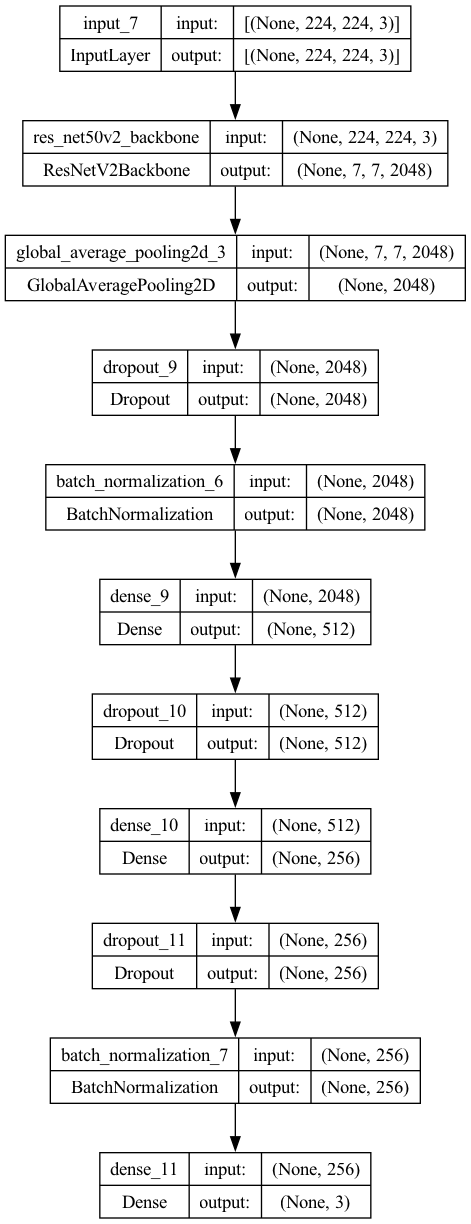

In [81]:
model = create_model()
keras.utils.plot_model(model, show_shapes=True)

### Callback function

In [82]:
# 記錄目前的 learning rate
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.lr

### Data visualization

In [83]:
dftrain, dfval = get_train_val_dataframes(configs['train_csv'])

train_ds = build_train_ds(dftrain)
val_ds = build_train_ds(dfval)
visualize_dataset(test_ds, 'Validation Dataset (without Augmentation)')

AttributeError: 'Series' object has no attribute 'image_id'

### Goal

由於資料不平衡 (imbalance)，因此我們研究的目的在於，是否可以應用一些技巧，解決資料不平衡的問題，並且讓模型的效能得以提升。

- Experiment 1: baseline，使用三個模型，加上 data augmentation 的技巧，試著做運動的影像分類。這三個模型是 resent50, efficientb0, 以及 ConvNeXtBase。這個實驗中，沒有使用任何解決 imbalance 的技巧，所以應該是效能最差的一個結果。因此底下其他的實驗都可以跟這個 baseline，看效能有沒有提升。

- Experiment 2:  使用 CutMix，CutOut 的 image augmentation 技巧，讓資料得以平衡。看能不能提升效能。